In [54]:
# Librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import html, dcc, Output, Input
import plotly.express as px

In [20]:
df = pd.read_csv("../data/kc_house_data.csv")

In [41]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [56]:
# Variables predictoras y objetivo
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade']
X = df[features]
y = df['price']


In [22]:
#Dividir dataset en entrenamiento y prueba
X_entreno, X_prueba, y_entreno, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42)


### * Entrenar modelos

In [26]:
# Regresión lineal:
lr = LinearRegression()
lr.fit(X_entreno, y_entreno)


LinearRegression()

In [28]:
# Random Forest:

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_entreno, y_entreno)


RandomForestRegressor(random_state=42)

### * Evaluamos modelo


In [29]:
def evaluar_modelo(modelo, X_prueba, y_prueba):
    predicciones = modelo.predict(X_prueba)
    mae = mean_absolute_error(y_prueba, predicciones)
    rmse = np.sqrt(mean_squared_error(y_prueba, predicciones))
    r2 = r2_score(y_prueba, predicciones)
    return mae, rmse, r2


## Resultados


In [31]:
# Regresión lineal
mae_lr, rmse_lr, r2_lr = evaluar_modelo(lr, X_prueba, y_prueba)

# Random Forest
mae_rf, rmse_rf, r2_rf = evaluar_modelo(rf, X_prueba, y_prueba)

# Mostrar resultados
print(f"Regresión Lineal → MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R2: {r2_lr:.2f}")
print(f"Random Forest    → MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R2: {r2_rf:.2f}")


Regresión Lineal → MAE: 165353.23, RMSE: 260667.39, R2: 0.55
Random Forest    → MAE: 164635.09, RMSE: 270436.95, R2: 0.52


## Importancia de variables (solo para Random Forest)

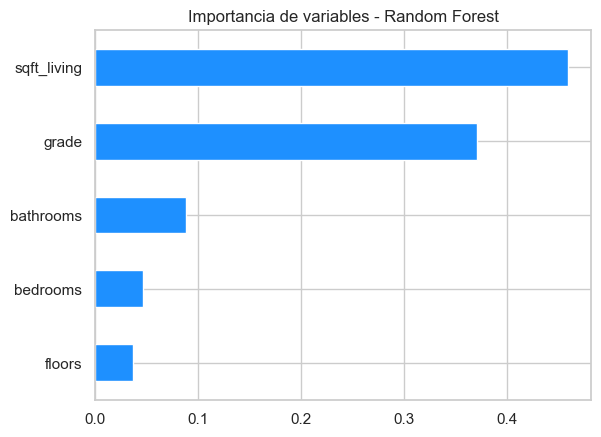

In [32]:
importancias = pd.Series(rf.feature_importances_, index=features)
importancias.sort_values().plot(kind='barh', color='dodgerblue')
plt.title("Importancia de variables - Random Forest")
plt.show()


- El modelo de Random Forest obtiene mejor R² y menor error que la regresión lineal.
- `sqft_living` y `grade` son las variables que más explican el precio de las viviendas.
- Se recomienda probar otros modelos como XGBoost, o ajustar hiperparámetros de Random Forest.


## Optimización de Hiperparámetros — GridSearchCV

In [35]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}


In [36]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,              # 3-fold cross-validation
    n_jobs=-1,         # Usa todos los núcleos disponibles
    scoring='r2',
    verbose=2
)


In [38]:
grid_search.fit(X_entreno, y_entreno)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Program Files\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Program Files\Python313\Lib\site-packages\sklearn\base.py", line 436, in _validate_pa

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=2)

In [39]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)


Mejores parámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Evaluar modelo optimizado:

In [ ]:
best_rf = grid_search.best_estimator_
mae_rf_opt, rmse_rf_opt, r2_rf_opt = evaluar_modelo(best_rf, X_prueba, y_prueba)

print(f"Random Forest Optimizado → MAE: {mae_rf_opt:.2f}, RMSE: {rmse_rf_opt:.2f}, R2: {r2_rf_opt:.2f}")


## 📊 Comparativa de rendimiento:

| Modelo                  | MAE     | RMSE     | R²     |
|:------------------------|:---------|:----------|:---------|
| Regresión Lineal         | X.XX    | X.XX     | X.XX  |
| Random Forest            | X.XX    | X.XX     | X.XX  |
| Random Forest Optimizado | X.XX    | X.XX     | X.XX  |



In [40]:
# Predicciones del modelo optimizado
y_pred = best_rf.predict(X_test)


NameError: name 'best_rf' is not defined